In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
from sklearn.metrics import mean_squared_error
import tensorflow 


In [2]:
from sklearn import metrics

In [3]:
## Data cleaning
# Read data from a CSV file
df = pd.read_csv("train_FD003.txt",sep=' ',header=None)
#Creating labels for dataset
Names= ['id','cycle','op1','op2','op3']
sensors=[]
for i in range(1,24):
    sensors.append("s"+ str(i))
Names.extend(sensors)
df.columns= Names
df.head()

,id,cycle,op1,op2,op3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,NaN,NaN
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,NaN,NaN
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,NaN,NaN
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,NaN,NaN
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,NaN,NaN


In [4]:
# Find missing values
missing_values = df.isnull().sum()
missing_values

id           0
cycle        0
op1          0
op2          0
op3          0
s1           0
s2           0
s3           0
s4           0
s5           0
s6           0
s7           0
s8           0
s9           0
s10          0
s11          0
s12          0
s13          0
s14          0
s15          0
s16          0
s17          0
s18          0
s19          0
s20          0
s21          0
s22      24720
s23      24720
dtype: int64

In [5]:
df.drop(labels=['s22','s23'],axis=1,inplace= True)

In [6]:
# Creating RUL-target column
def add_rul(c):
    c['RUL']= max(c['cycle'])- c['cycle']
    return c
train=df.groupby('id',group_keys=False).apply(add_rul)

In [7]:
cycle_engine= train[['id','cycle']].groupby('id').max().sort_values(by="cycle",ascending= True)
ceng_idx= cycle_engine.index.to_list()
ceng_val= list(cycle_engine.cycle.values)

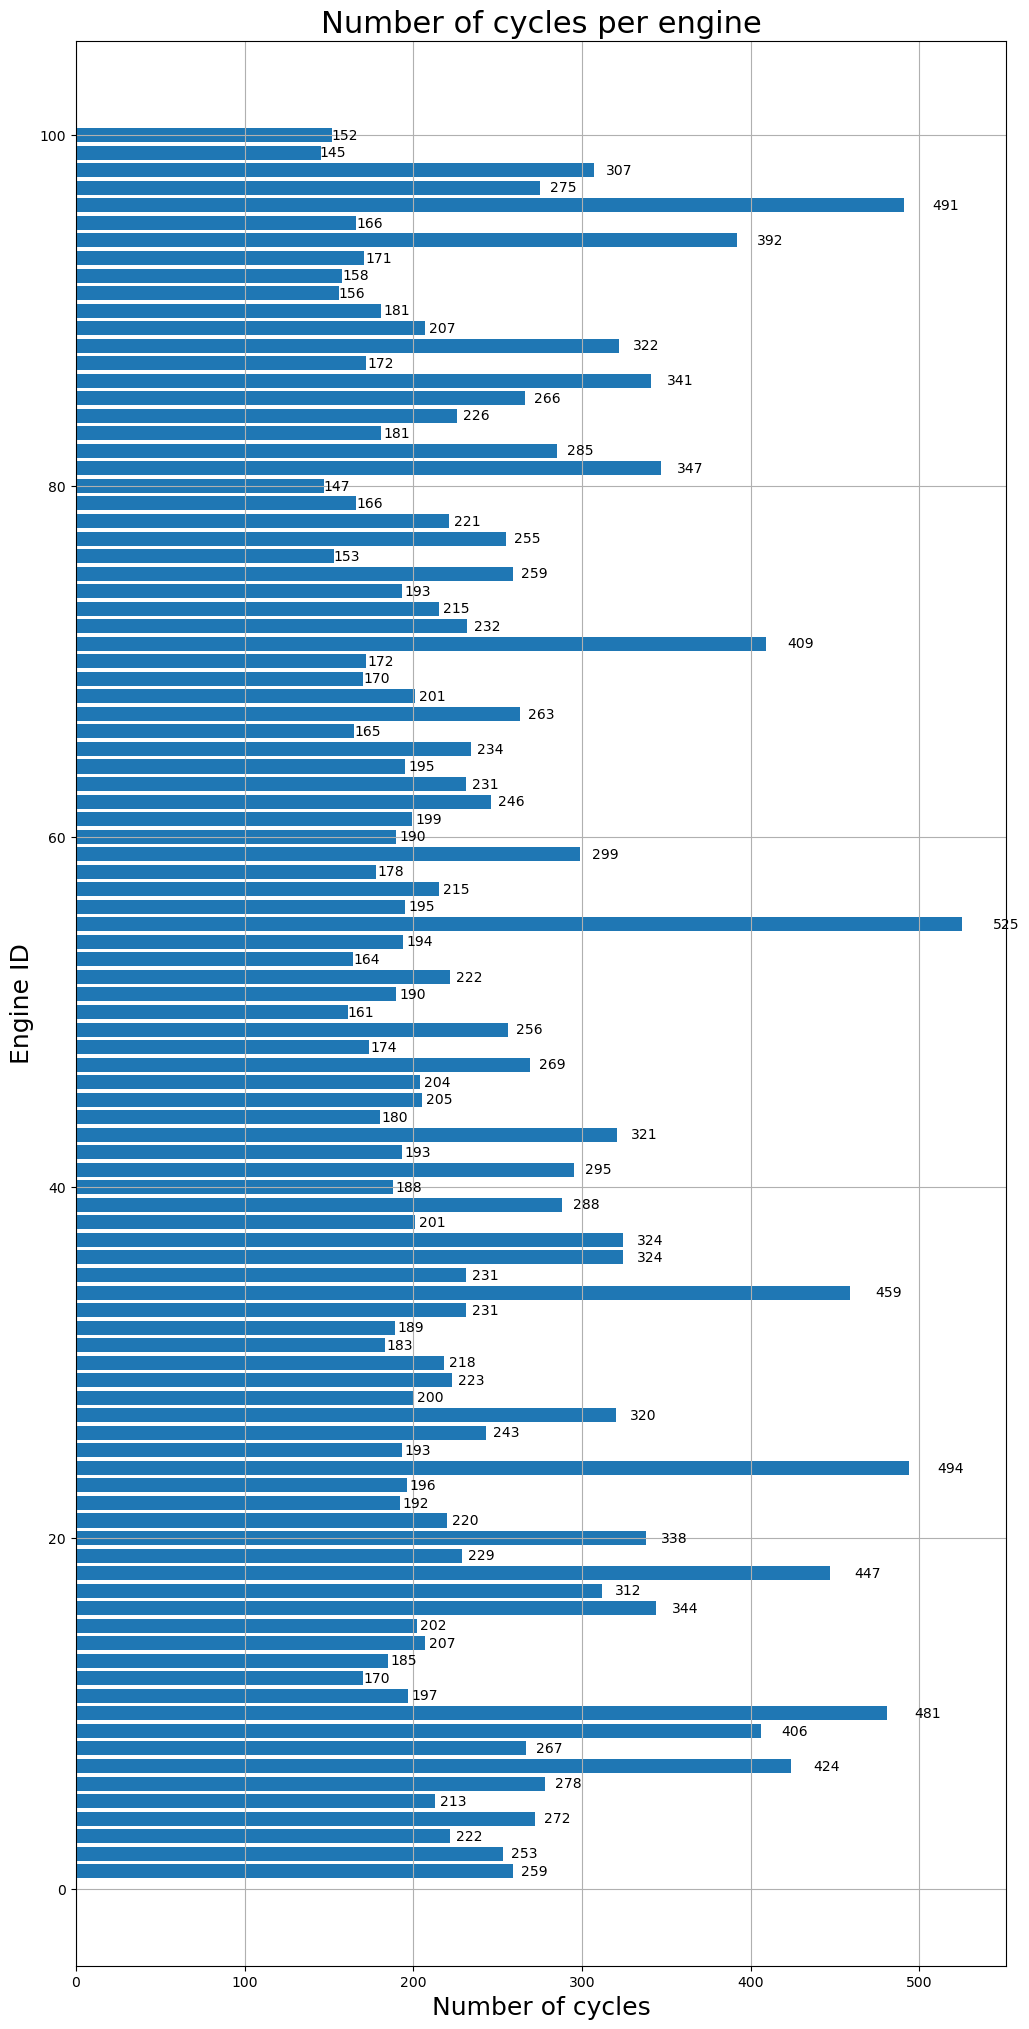

In [8]:
fig,ax= plt.subplots(figsize=(12,25))
plots= ax.barh(ceng_idx,ceng_val)
ax.set_title("Number of cycles per engine",fontsize=22)
ax.set_xlabel("Number of cycles",fontsize=18)
ax.set_ylabel("Engine ID",fontsize=18)
ax.grid(True)
#for annotating bars
for p in plots:
    width= p.get_width()
    plt.text(1.05*width,p.get_y()+0.5*p.get_height(), '%d' % int(width), ha='center', va='center')

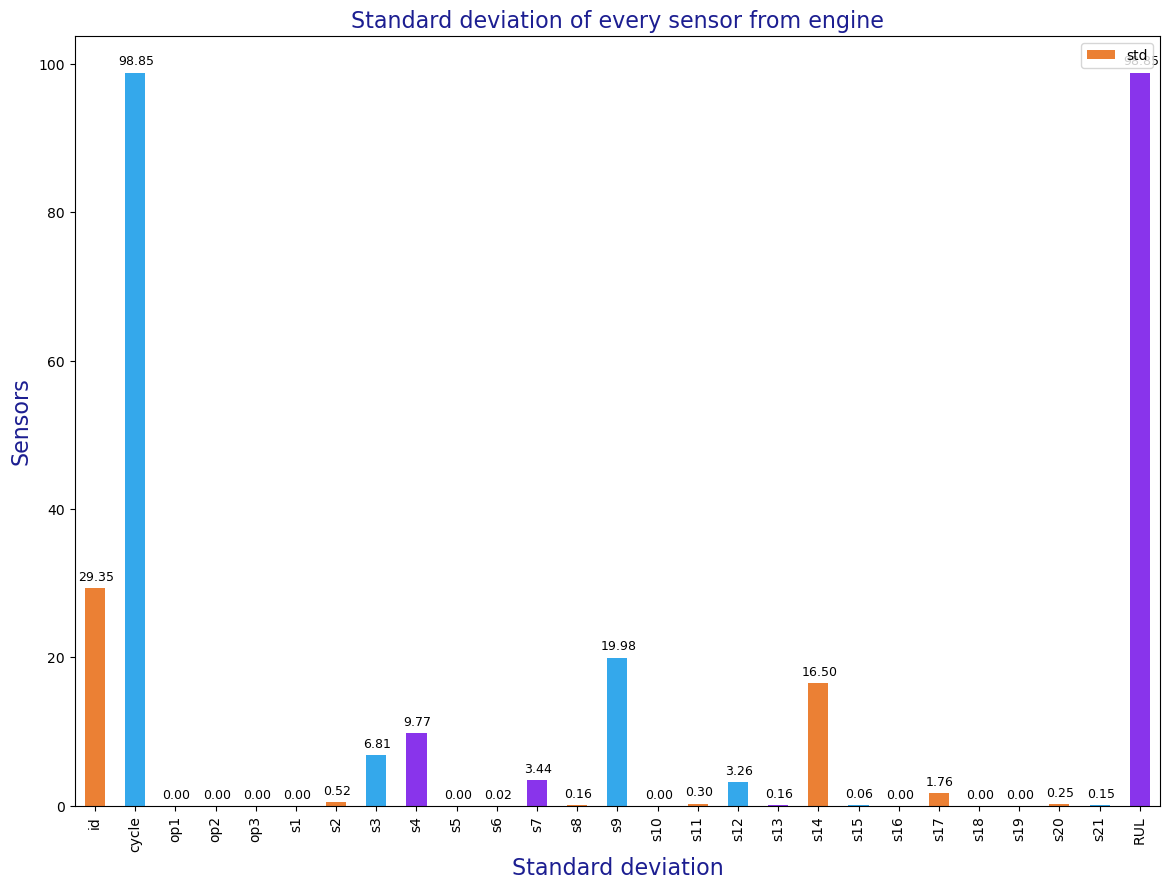

In [9]:
stats_std= train.agg(["mean","std"]).T
ax=stats_std.plot.bar(y="std",color= ['#eb8034','#34a8eb','#8934eb'],figsize=(14,10))
ax.set_title("Standard deviation of every sensor from engine",color='#1c1e91',fontsize=16)
ax.set_xlabel("Standard deviation",fontsize=16,color='#1c1e91')
ax.set_ylabel("Sensors",fontsize=16,color='#1c1e91')
for plot in ax.patches:
    ax.annotate(format(plot.get_height(), '.2f'),
                   (plot.get_x() + plot.get_width() / 2,
                    plot.get_height()), ha='center', va='center',
                   size=9, xytext=(0.8, 8),
                   textcoords='offset points')


In [10]:
import random
np.random.seed(21)

## Feature Engineering

In [11]:
def process_targets(data_length, early_rul= None):
    """ datalength and earlyrul as input and creates target rul"""
    if early_rul == None:
        return np.arange(data_length-1,-1,-1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <=0:
            return np.arange(data_length-1,-1,-1)
        else:
            return np.append(early_rul*np.ones( shape= (early_rul_duration,)),np.arange(early_rul-1,-1,-1))

In [12]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets 
    from input_data and target_data.
    
    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1
    
    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is 
    produced as output.**
    
    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.
        
    """
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets


In [13]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins. 
    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.
    
    The function return last examples and number of last examples (a scaler) as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          windoحw_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows


In [14]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins. 
    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.
    
    The function return last examples and number of last examples (a scaler) as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          windoحw_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In [15]:
test_data = pd.read_csv("test_FD003.txt", sep = "\s+", header = None,names= Names)
true_rul = pd.read_csv("RUL_FD003.txt", sep = '\s+', header = None)

In [16]:
test_data.head()

,id,cycle,op1,op2,op3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,1,1,-0.0017,-0.0004,100.0,518.67,641.94,1581.93,1396.93,14.62,...,8133.48,8.3760,0.03,391,2388,100.0,39.07,23.4468,NaN,NaN
1,1,2,0.0006,-0.0002,100.0,518.67,642.02,1584.86,1398.90,14.62,...,8137.44,8.4062,0.03,391,2388,100.0,39.04,23.4807,NaN,NaN
2,1,3,0.0014,-0.0003,100.0,518.67,641.68,1581.78,1391.92,14.62,...,8138.25,8.3553,0.03,391,2388,100.0,39.10,23.4244,NaN,NaN
3,1,4,0.0027,0.0001,100.0,518.67,642.20,1584.53,1395.34,14.62,...,8137.07,8.3709,0.03,392,2388,100.0,38.97,23.4782,NaN,NaN
4,1,5,-0.0001,0.0001,100.0,518.67,642.46,1589.03,1395.86,14.62,...,8134.20,8.4146,0.03,391,2388,100.0,39.09,23.3950,NaN,NaN


In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:

train

,id,cycle,op1,op2,op3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,100,148,-0.0016,-0.0003,100.0,518.67,643.78,1596.01,1424.11,14.62,...,2388.30,8138.08,8.5036,0.03,394,2388,100.0,38.44,22.9631,4
24716,100,149,0.0034,-0.0003,100.0,518.67,643.29,1596.38,1429.14,14.62,...,2388.28,8144.36,8.5174,0.03,395,2388,100.0,38.50,22.9746,3
24717,100,150,-0.0016,0.0004,100.0,518.67,643.84,1604.53,1431.41,14.62,...,2388.24,8135.95,8.5223,0.03,396,2388,100.0,38.39,23.0682,2
24718,100,151,-0.0023,0.0004,100.0,518.67,643.94,1597.56,1426.57,14.62,...,2388.26,8141.24,8.5148,0.03,395,2388,100.0,38.31,23.0753,1


Independent features with std dev=0 are dropped along with the rul label generated prior for the training data. Sliding window/ lag method is applied to transform the data into time series supervised learning problem. The test and train datasets are normalised using MinMaxScaler.

In [19]:
columns_to_be_dropped =['id','op1','op2','op3', 's1', 's5', 's6','s10',
                 's16', 's18', 's19','RUL']
#[0,1,2,3,4,5,9,10,11,14,20,21,22,23,24,25]
window_length = 30
shift = 1
early_rul = 125           
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for 
# each engine is taken. If set to a different number, that many windows from last are taken. 
# Final output is the average output of all windows.
num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []

#columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]
columns_to_be_dropped_test =['id','op1','op2','op3', 's1', 's5', 's6','s10',
                 's16', 's18', 's19','s22','s23']
train_data_first_column = train['id']
test_data_first_column = test_data['id']

# Scale data for all engines
scaler = MinMaxScaler(feature_range = (-1,1))

train= scaler.fit_transform(train.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped_test))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process training data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]
print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (21820, 30, 15)
Processed training ruls shape:  (21820,)
Processed test data shape:  (500, 30, 15)
True RUL shape:  (100,)


/var/folders/tz/41r1wyqd0dn5rybgljxvq4yr0000gn/T/ipykernel_35367/81239474.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
/var/folders/tz/41r1wyqd0dn5rybgljxvq4yr0000gn/T/ipykernel_35367/81239474.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

In [20]:
df

,id,cycle,op1,op2,op3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,100,148,-0.0016,-0.0003,100.0,518.67,643.78,1596.01,1424.11,14.62,...,519.66,2388.30,8138.08,8.5036,0.03,394,2388,100.0,38.44,22.9631
24716,100,149,0.0034,-0.0003,100.0,518.67,643.29,1596.38,1429.14,14.62,...,519.91,2388.28,8144.36,8.5174,0.03,395,2388,100.0,38.50,22.9746
24717,100,150,-0.0016,0.0004,100.0,518.67,643.84,1604.53,1431.41,14.62,...,519.44,2388.24,8135.95,8.5223,0.03,396,2388,100.0,38.39,23.0682
24718,100,151,-0.0023,0.0004,100.0,518.67,643.94,1597.56,1426.57,14.62,...,520.01,2388.26,8141.24,8.5148,0.03,395,2388,100.0,38.31,23.0753


In [21]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (17456, 30, 15)
Processed validation data shape:  (4364, 30, 15)
Processed train targets shape:  (17456,)
Processed validation targets shape:  (4364,)


In [22]:
# Export processed train data and test data for visualizations
np.save('processed_train_data.npy',processed_train_data)
np.save('processed_test_data.npy',processed_test_data)

In [23]:
#loading the saved test data 
a= np.load('processed_test_data.npy')
a[:30].shape

(30, 30, 15)

## TCN model

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D
from keras.layers import Dropout, Input
from keras import initializers
from keras.layers import MaxPooling1D
from keras.models import Model 
from keras.layers import TimeDistributed, Flatten
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM

In [21]:
from tcn import TCN, tcn_full_summary, compiled_tcn

In [23]:
## Baseline Model

In [24]:
model = Sequential([
    TCN(input_shape=(window_length, processed_train_data.shape[2]),
        kernel_size=2,
        use_skip_connections=False,
        use_batch_norm=False,
        use_weight_norm=False,
        use_layer_norm=False
        ),
    Dense(1, activation='linear'),
    Dense(1)
])
"""Conv1D(128,kernel_size=3, padding = "same", activation="relu"),
    Dropout(0),
    MaxPooling1D(pool_size=2, padding='same'),
    TimeDistributed(Flatten()),
    LSTM(units = 128, return_sequences=True),
    LSTM(units = 128, return_sequences=False),
    extractor = Model(inputs=ecg_input,outputs=model.get_layer('flatten').output)- to get output of conv1d to feed to tcn"""

'Conv1D(128,kernel_size=3, padding = "same", activation="relu"),\n    Dropout(0),\n    MaxPooling1D(pool_size=2, padding=\'same\'),\n    TimeDistributed(Flatten()),\n    LSTM(units = 128, return_sequences=True),\n    LSTM(units = 128, return_sequences=False),\n    extractor = Model(inputs=ecg_input,outputs=model.get_layer(\'flatten\').output)- to get output of conv1d to feed to tcn'

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 64)                93824     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 93,891
Trainable params: 93,891
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001),loss='MSE')

In [27]:
#model.fit(x, y, epochs=100, verbose=2)
def scheduler(epoch):
    if epoch < 5:
        return 0.001
    else:
        return 0.0001
callback = tensorflow.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
history = model.fit(processed_train_data, processed_train_targets, epochs = 10,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = [callback],
                    batch_size = 64, verbose = 2)

Train on 17456 samples, validate on 4364 samples
Metal device set to: Apple M1 Pro

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10


2023-05-08 09:20:04.413670: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-08 09:20:04.414003: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-05-08 09:20:04.431292: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-05-08 09:20:04.441032: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-08 09:20:04.444310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-08 09:20:04.488878: I tensorflow/core/grappler/optimizers/custom_graph

17456/17456 - 18s - loss: 616.7437 - val_loss: 191.4579 - lr: 0.0010 - 18s/epoch - 1ms/sample

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
17456/17456 - 17s - loss: 164.7635 - val_loss: 154.9906 - lr: 0.0010 - 17s/epoch - 964us/sample

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
17456/17456 - 17s - loss: 134.3131 - val_loss: 155.1801 - lr: 0.0010 - 17s/epoch - 967us/sample

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
17456/17456 - 17s - loss: 120.4861 - val_loss: 143.7265 - lr: 0.0010 - 17s/epoch - 984us/sample

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
17456/17456 - 17s - loss: 115.7776 - val_loss: 115.3169 - lr: 0.0010 - 17s/epoch - 987us/sample

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6/10
17456/17456 - 17s - loss: 89.0181 - val_loss: 93.2101 - lr: 1.0000e-04 - 17s/epoch - 990us/sample

Epoch 7: LearningRateScheduler setting learning

In [28]:
#prediction
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2023-05-08 09:25:13.736756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


RMSE:  14.305074344594745


In [26]:
import sklearn.metrics as metrics

In [22]:
def get_regression_metrics(model, actual, predicted):
    
    """Calculate main regression metrics.
    
    Args:
        model (str): The model name identifier
        actual (series): Contains the test label values
        predicted (series): Contains the predicted values
        
    Returns:
        dataframe: The combined metrics in single dataframe
    
    
    """
    regr_metrics = {
        'Root Mean Squared Error' : metrics.mean_squared_error(actual, predicted)**0.5,
        'Mean Absolute Error' : metrics.mean_absolute_error(actual, predicted),
        'R^2' : metrics.r2_score(actual, predicted),
        'Explained Variance' : metrics.explained_variance_score(actual, predicted),
        'MAPE': metrics.mean_absolute_percentage_error(actual,predicted)
    }

    #return reg_metrics
    df_regr_metrics = pd.DataFrame.from_dict(regr_metrics, orient='index')
    df_regr_metrics.columns = [model]
    return df_regr_metrics

In [31]:
tcn_metrics= get_regression_metrics('TCN',true_rul,mean_pred_for_each_engine)

In [32]:
tcn_metrics

,TCN
Root Mean Squared Error,14.305074
Mean Absolute Error,10.505450
R^2,0.880582
Explained Variance,0.882436
MAPE,0.157244


In [ ]:
#TCN model
model = Sequential([
    TCN(input_shape=(window_length, processed_train_data.shape[2]),
        kernel_size=2,
        use_skip_connections=False,
        use_batch_norm=False,
        use_weight_norm=False,
        use_layer_norm=False
        ),
    Dense(1, activation='linear'),
    Dense(1)
])
"""Conv1D(128,kernel_size=3, padding = "same", activation="relu"),
    Dropout(0),
    MaxPooling1D(pool_size=2, padding='same'),
    TimeDistributed(Flatten()),
    LSTM(units = 128, return_sequences=True),
    LSTM(units = 128, return_sequences=False),
    extractor = Model(inputs=ecg_input,outputs=model.get_layer('Conv1D').output)- to get output of conv1d to feed to tcn"""

In [ ]:
"""def create_compiled_model(lr=0.001, drop_CNN=0, drop_dense=0.2, kernel_size=3):
    model = Sequential()
    intput_shape=(window_length, processed_train_data.shape[2])
    model.add(Conv1D(128, kernel_size=kernel_size, padding = "same", activation="relu", input_shape = intput_shape))
    model.add(Dropout(drop_CNN))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Conv1D(128,kernel_size=kernel_size, padding = "same", activation="relu"))
    model.add(Dropout(drop_CNN))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(units = 128, return_sequences=True))
    model.add(LSTM(units = 128, return_sequences=False))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(drop_dense))
    model.add(Dense(1, activation = 'linear'))
    model.add(Dense(1))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse')
    return model"""

## LSTM-TCN Model

In [23]:
from keras.regularizers import l1,l2 ,l1_l2

In [36]:
def compiled_model(lr=0.001,drop_CNN=0,drop_dense=0.2,kernel_size=3):
    model= Sequential()
    input_shape= (window_length, processed_train_data.shape[2])
    model.add(TCN(input_shape= input_shape,kernel_size=2,use_skip_connections=False,use_batch_norm=False, use_weight_norm=False,
                  use_layer_norm=False,return_sequences=True))
    #model.add(Conv1D(128, kernel_size=kernel_size, padding = "same", activation="relu"))
    #model.add(Dropout(drop_CNN))
    #model.add(MaxPooling1D(pool_size=2, padding='same'))
    #model.add(Conv1D(128,kernel_size=kernel_size, padding = "same", activation="relu"))
    #model.add(Dropout(drop_CNN))
    #model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(units = 128, return_sequences=True))
    model.add(LSTM(units = 64, return_sequences=False))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(drop_dense))
    model.add(Dense(1, activation = 'relu'))
    model.add(Dense(1))
    opt = tensorflow.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse')
    return model

In [24]:
#for cnn-tcn-lstm
# def compiled_model(lr=0.001,drop_CNN=0.3,drop_dense=0,kernel_size=3):
#     model= Sequential()
#     input_shape= (window_length, processed_train_data.shape[2])
#     model.add(TCN(input_shape= input_shape,kernel_size=2,use_skip_connections=False,use_batch_norm=False, use_weight_norm=False,
#         use_layer_norm=False,return_sequences=True))
#     model.add(Conv1D(128, kernel_size=kernel_size, padding = "same", activation="relu",kernel_regularizer=l1(0.01)))
#     model.add(Dropout(drop_CNN))
#     model.add(MaxPooling1D(pool_size=2, padding='same'))
#     #model.add(Conv1D(128,kernel_size=kernel_size, padding = "same", activation="relu"))
#     #model.add(Dropout(drop_CNN))
#     #model.add(MaxPooling1D(pool_size=2, padding='same'))
#     model.add(TimeDistributed(Flatten()))
#     model.add(LSTM(units = 128, return_sequences=True))
#     model.add(LSTM(units = 64, return_sequences=False))
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(drop_dense))
#     model.add(Dense(1, activation = 'relu'))
#     model.add(Dense(1))
#     opt = tf.keras.optimizers.Adam(learning_rate=lr)
#     model.compile(optimizer=opt, loss='mse')
#     return model

In [25]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [55]:
def scheduler(epoch):
    if epoch < 5:
        return 0.001
    else:
        return 0.0001
callback = tensorflow.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
model_lstm_tcn = compiled_model()
history = model_lstm_tcn.fit(processed_train_data, processed_train_targets, epochs = 10,
                    validation_data = (processed_val_data, processed_val_targets),callbacks=[callback],
                    batch_size = 64, verbose = 2)

Train on 17456 samples, validate on 4364 samples


2023-05-13 22:54:26.052356: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-05-13 22:54:26.077959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-13 22:54:26.180955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10


2023-05-13 22:54:26.318583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-13 22:54:26.379139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-13 22:54:26.398738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2023-05-13 22:55:41.702237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17456/17456 - 84s - loss: 3908.7445 - val_loss: 212.6136 - lr: 0.0010 - 84s/epoch - 5ms/sample

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
17456/17456 - 84s - loss: 181.4877 - val_loss: 127.2584 - lr: 0.0010 - 84s/epoch - 5ms/sample

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
17456/17456 - 78s - loss: 140.9135 - val_loss: 102.0654 - lr: 0.0010 - 78s/epoch - 4ms/sample

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
17456/17456 - 81s - loss: 120.0396 - val_loss: 106.4080 - lr: 0.0010 - 81s/epoch - 5ms/sample

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
17456/17456 - 78s - loss: 111.8966 - val_loss: 116.7067 - lr: 0.0010 - 78s/epoch - 4ms/sample

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6/10
17456/17456 - 81s - loss: 85.5430 - val_loss: 79.6464 - lr: 1.0000e-04 - 81s/epoch - 5ms/sample

Epoch 7: LearningRateScheduler setting learning rate to 

In [56]:
print(model_lstm_tcn.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_4 (TCN)                 (None, 30, 64)            93824     
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 64)           0         
 tributed)                                                       
                                                                 
 lstm_8 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dense_12 (Dense)            (None, 128)               8320      
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                      

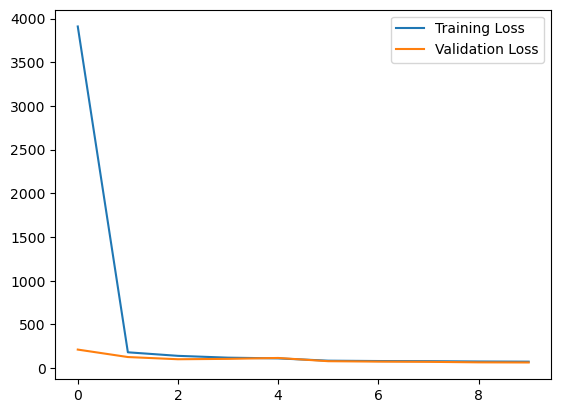

In [57]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

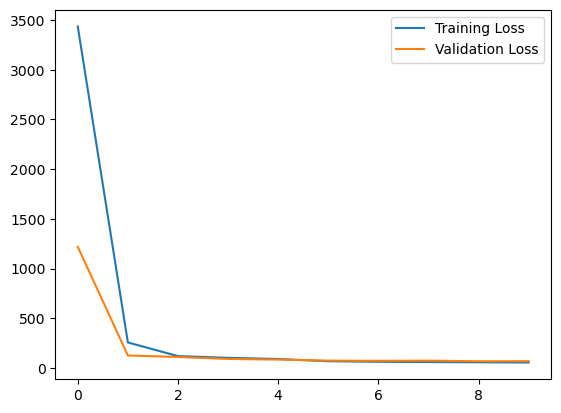

In [90]:
#for tcn-cnn-lstm
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show() 

## Saving the keras model using API 

In [58]:
model_lstm_tcn.save('tcn_lstm_model/tcn_lstm_fd003')

2023-05-13 23:08:37.030934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-13 23:08:37.044369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-13 23:08:37.061064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-13 23:08:37.073352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-13 23:08:37.084431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-13 23:08:37.098870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-13 23:08:37.118721: I tensorflow/core/grappler/optimizers/cust

In [23]:
#to reconstruct the model identically.
from tensorflow import keras
reconstructed_model = keras.models.load_model("tcn_lstm_model/tcn_lstm_fd003",
                                              custom_objects={"TCN":TCN })

Metal device set to: Apple M1 Pro


2023-05-20 17:20:00.264645: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-20 17:20:00.264833: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [24]:
rul_pred = reconstructed_model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

2023-05-20 17:20:21.651417: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-20 17:20:21.884528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-20 17:20:22.132541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-20 17:20:22.240023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 49ms/step
RMSE:  14.293813413483193


In [44]:
#Saving and exporting the num_of_test_windows_list
np.save("num_test_windows_list.npy",num_test_windows_list)

In [47]:
""""# load json and create model
json_file = open('tcnlstm_fd003.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json,custom_objects={"TCN":TCN})
# load weights into new model
loaded_model.load_weights("tcnlstm_fd003.h5")
print("Loaded model from disk")"""

'"# load json and create model\njson_file = open(\'tcnlstm_fd003.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\nloaded_model = model_from_json(loaded_model_json,custom_objects={"TCN":TCN})\n# load weights into new model\nloaded_model.load_weights("tcnlstm_fd003.h5")\nprint("Loaded model from disk")'

## Predictions on Test

In [45]:
rul_pred = model_lstm_tcn.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

NameError: name 'model_lstm_tcn' is not defined

In [91]:
#for tcn-cnn-lstm
rul_pred = model_tcn_cnn_lstm.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2023-05-13 02:43:35.676157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


RMSE:  16.31999109600908


In [40]:
import sklearn.metrics as metrics

In [99]:
def get_regression_metrics(model, actual, predicted):
    
    """Calculate main regression metrics.
    "
    Args:
        model (str): The model name identifier
        actual (series): Contains the test label values
        predicted (series): Contains the predicted values
        
    Returns:
        dataframe: The combined metrics in single dataframe
    
    
    """
    regr_metrics = {
                        'Root Mean Squared Error' : metrics.mean_squared_error(actual, predicted)**0.5,
                        'Mean Absolute Error' : metrics.mean_absolute_error(actual, predicted),
                        'R^2' : metrics.r2_score(actual, predicted),
                        'Explained Variance' : metrics.explained_variance_score(actual, predicted),
                        'MAPE': metrics.mean_absolute_percentage_error(actual,predicted)
                   }

    #return reg_metrics
    df_regr_metrics = pd.DataFrame.from_dict(regr_metrics, orient='index')
    df_regr_metrics.columns = [model]
    return df_regr_metrics

In [25]:
tcn_lstm_metrics= get_regression_metrics('TCN-LSTM',true_rul,mean_pred_for_each_engine)

In [26]:
tcn_lstm_metrics

,TCN-LSTM
Root Mean Squared Error,14.293813
Mean Absolute Error,10.552544
R^2,0.880769
Explained Variance,0.881491
MAPE,0.159057


## SHAP

In [22]:

import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()
import shap
shap.initjs()

Instructions for updating:
non-resource variables are not supported in the long term


In [70]:
print("SHAP version is:", shap.__version__)
print("Tensorflow version is:", tf.__version__)

SHAP version is: 0.41.0
Tensorflow version is: 2.9.0


In [23]:
processed_test_data.shape

(500, 30, 15)

In [ ]:
rul_pred = reconstructed_model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))

In [96]:
rul_pred.shape

(500,)

In [78]:
processed_test_data.shape

(500, 30, 15)

In [25]:
last_window_all= []
for i in range(500):
    last_window_all.append(processed_test_data[i][-1])

In [31]:
rul_pred

array([ 50.326237 ,  48.856495 ,  49.61485  ,  46.25082  ,  44.210373 ,
        58.84833  ,  53.31352  ,  60.948185 ,  54.360115 ,  57.330532 ,
        28.90879  ,  28.353466 ,  28.528162 ,  28.862564 ,  27.281216 ,
       116.86298  , 117.13918  , 118.09504  , 118.60376  , 119.77777  ,
       116.57763  , 116.052025 , 117.00362  , 115.77699  , 102.05449  ,
       112.35082  , 113.00581  , 114.548004 , 110.45373  , 102.87095  ,
        61.33144  ,  54.773823 ,  47.299835 ,  50.44687  ,  44.944523 ,
       100.74214  ,  86.95985  ,  68.192566 ,  65.700584 ,  59.80096  ,
        73.009674 ,  74.104675 ,  76.81311  ,  71.29584  ,  66.38344  ,
        81.88688  ,  77.051636 ,  71.212845 ,  68.99366  ,  68.17321  ,
        59.149998 ,  64.623634 ,  70.26275  ,  76.57268  ,  80.66406  ,
       108.154724 , 111.72234  , 111.584656 , 111.53904  , 110.78511  ,
       109.00859  , 112.75903  , 115.640625 , 113.938965 , 115.13094  ,
        31.511993 ,  30.701254 ,  28.930134 ,  28.08556  ,  27.8

In [40]:
last_window_all= np.array(last_window_all)

In [41]:
last_window_all

array([[-0.12977099,  0.00234192, -0.11411235, ..., -0.09090909,
         0.25      ,  0.06744596],
       [-0.1259542 , -0.08196721,  0.13446858, ..., -0.09090909,
         0.42857143,  0.36691715],
       [-0.1221374 , -0.11007026, -0.06087297, ..., -0.09090909,
         0.39285714,  0.37934873],
       ...,
       [-0.06870229, -0.12880562,  0.15521628, ...,  0.09090909,
         0.5       ,  0.25354857],
       [-0.0648855 , -0.3676815 ,  0.2264631 , ...,  0.27272727,
         0.46428571,  0.47713146],
       [-0.0610687 ,  0.10070258,  0.1055001 , ..., -0.27272727,
         0.47619048,  0.44911402]])

In [26]:
np.array(last_window_all).shape
np.save("actual_engine_last")

(500, 15)

In [88]:
true_rul[5]

99

In [112]:
explainer= shap.DeepExplainer(reconstructed_model,processed_train_data[:100]) #model_lstm_tcn

#explain first 30 predictions
#explaining each prediction 
shap_values= explainer.shap_values(processed_test_data[:30])

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
2023-05-19 18:56:36.255276: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-19 18:56:36.255319: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


TypeError: Tensors are unhashable (this tensor: KerasTensor(type_spec=TensorSpec(shape=(?, 30, 15), dtype=tf.float32, name='tcn_4_input'), name='tcn_4_input', description="created by layer 'tcn_4_input'")). Instead, use tensor.ref() as the key.

In [89]:
shap_values[0][0][0].reshape(1,-1).shape

(1, 15)

In [116]:
true_rul

array([ 44,  51,  27, 120, 101,  99,  71,  55,  55,  66,  77, 115, 115,
        31, 108,  56, 136, 132,  85,  56,  18, 119,  78,   9,  58,  11,
        88, 144, 124,  89,  79,  55,  71,  65,  87, 137, 145,  22,   8,
        41, 131, 115, 128,  69, 111,   7, 137,  55, 135,  11,  78, 120,
        87,  87,  55,  93,  88,  40,  49, 128, 129,  58, 117,  28, 115,
        87,  92, 103, 100,  63,  35,  45,  99, 117,  45,  27,  86,  20,
        18, 133,  15,   6, 145, 104,  56,  25,  68, 144,  41,  51,  81,
        14,  67,  10, 127, 113, 123,  17,   8,  28])

In [119]:
len(preds_for_each_engine)

100

In [107]:
g_exp= shap.GradientExplainer(reconstructed_model, processed_train_data[:100])
#explain first 12 predictions
shap_vals= g_exp.shap_values(processed_test_data[:24])


2023-05-18 15:02:52.383417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [192]:
shap_vals[0][14][24]

array([  1.97968781,   0.39564294,   0.04476957,   0.23480541,
        -5.65388918,  -5.66723585,  -1.55717778,  -0.88959146,
       -12.4592371 ,  -3.27854848,  -0.20229274,  -0.57980067,
         0.18101312,  -0.376847  ,  -0.17312188])

In [60]:
df_explain=pd.read_csv('eda-dash/data/02_interim/test_FD003.csv')
cols_to_drop= ['Engine_no','Altitude','Mach','TRA','T2','P2','P15','epr','farB','Nf_dmd', 'PCNfR_dmd']
df_explain=df_explain.drop(columns=cols_to_drop)

In [61]:
df_explain.drop('RUL',axis=1,inplace=True)

In [62]:
df_explain.shape

(16596, 15)

In [220]:
shap_vals[0][24].shape

IndexError: index 24 is out of bounds for axis 0 with size 24

In [44]:
shap.summary_plot(shap_vals[0][0],processed_test_data[:24][0] ,feature_names=df_explain.columns,show=False)
plt.savefig('shap_summary_plot_24.png', dpi=500,bbox_inches='tight')
plt.clf()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


<Figure size 800x750 with 0 Axes>

In [224]:
processed_test_data[:30][0].shape

(30, 15)

In [225]:
shap.summary_plot(shap_values[0][29],processed_test_data[:30][29] ,feature_names=df_explain.columns,show=False)
plt.savefig('shap_summary_plot_30.jpg', dpi=500,bbox_inches='tight')
plt.clf()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [150]:
shap_values[0].shape

(30, 30, 15)

In [74]:
shap_values[0].shape

NameError: name 'shap_values' is not defined

In [178]:
true_rul[29]

89

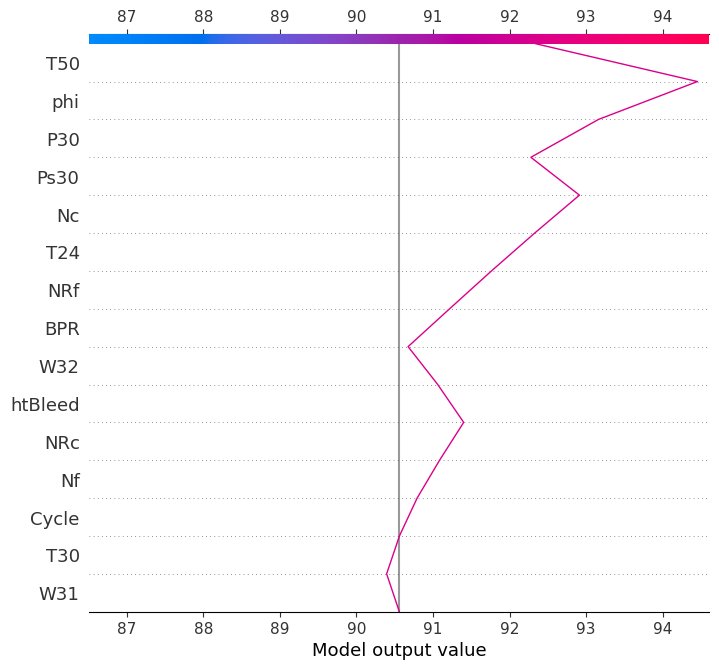

AttributeError: 'NoneType' object has no attribute 'savefig'

In [196]:
#for engine no 29 

fig_decision= shap.decision_plot(explainer.expected_value[0], shap_values[0][29][-1], df_explain.columns)



In [137]:
explainer.expected_value

array([90.56064], dtype=float32)

In [199]:
np.cumsum([[1,2,3,4],[2,4,6,9]])

array([ 1,  3,  6, 10, 12, 16, 22, 31])

In [176]:
print('output value: '+str(np.sum(shap_values[0][0][0])+ base_value))
print('expected output value: '+ str(pred[-2][0]))

output value: 94.12201982511073
expected output value: 70.186516


In [216]:
#columns_to_be_dropped =['id','op1','op2','op3', 's1', 's5','s10','s16', 's18', 's19','RUL']
#[0,1,2,3,4,5,9,14,20,22,23]
new_df=['s2','s3','s4','s6','s7','s8','s9','s11','s12','s13','s14','s15','s17','s20','s21']
fig_shap = shap.force_plot(explainer.expected_value[0], shap_values[0][29][-1].reshape(1,-1),df_explain.columns,matplotlib=True, show=False)
fig_shap.set_facecolor('white')
fig_shap.savefig('single sample rul-engine 29 last window.jpg', bbox_inches = 'tight', dpi=500)
plt.clf()

In [215]:
scaled_temp

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-1.000000,-0.484778,-0.309845,-0.380031,-0.525862,0.211765,-0.716504,-0.542857,-0.580234,0.202381,-0.645832,0.060840,-0.454545,0.071429,0.065405
1,-0.996183,-0.447307,-0.195146,-0.318565,-0.569923,0.223529,-0.736100,-0.554286,-0.584310,0.285714,-0.604338,0.206663,-0.454545,0.035714,0.128305
2,-0.992366,-0.606557,-0.315717,-0.536349,-0.540230,0.258824,-0.658548,-0.474286,-0.558839,0.202381,-0.595851,-0.039112,-0.454545,0.107143,0.023843
3,-0.988550,-0.362998,-0.208064,-0.429641,-0.523946,0.223529,-0.657439,-0.348571,-0.523179,0.226190,-0.608215,0.036214,-0.272727,-0.047619,0.123666
4,-0.984733,-0.241218,-0.031904,-0.413417,-0.564176,0.305882,-0.717059,-0.714286,-0.578197,0.238095,-0.638288,0.247224,-0.454545,0.095238,-0.030708
5,-0.980916,-0.578454,-0.273048,-0.376599,-0.533525,0.305882,-0.658640,-0.485714,-0.508915,0.333333,-0.637450,0.006277,-0.636364,-0.035714,-0.012153
6,-0.977099,-0.358314,-0.299276,-0.385023,-0.544061,0.270588,-0.686925,-0.600000,-0.502802,0.297619,-0.575418,0.148720,-0.636364,-0.011905,-0.111977
7,-0.973282,-0.503513,-0.302408,-0.278003,-0.534483,0.341176,-0.685446,-0.485714,-0.515028,0.261905,-0.600147,0.111057,-0.454545,0.130952,-0.008628
8,-0.969466,-0.170960,-0.292621,-0.312324,-0.527778,0.317647,-0.701807,-0.554286,-0.509934,0.285714,-0.621732,0.036697,-0.272727,0.214286,-0.056128
9,-0.965649,-0.756440,-0.094148,-0.375663,-0.517241,0.329412,-0.661044,-0.360000,-0.518085,0.321429,-0.554252,0.152583,-0.272727,0.261905,0.077651


In [120]:
processed_train_data[:1000].shape

(1000, 30, 15)

In [122]:
#Saving for production
np.save(file='model/bg_seq_array_data.npy', arr=processed_train_data[:1000])

In [273]:
np.abs(shap_values[0][:]).sum(axis=1)

array([[ 71.69214173,   5.58499208,   2.72690944,   6.78319452,
         84.59790855,  39.67693441,  19.54709211,   4.47717509,
        147.05918465,  24.63388278,   3.02891194,  13.12858097,
          4.30553125,   7.12606614,   9.28117438],
       [ 71.89577998,   5.56564748,   2.91923903,   6.48463013,
         84.74618621,  40.07822665,  19.99836674,   5.82230151,
        148.00666261,  24.32468573,   2.68106587,  12.94317221,
          5.09068669,   7.53720772,   8.38912485],
       [ 76.16269402,   5.92954316,   3.24274211,   5.8625606 ,
         88.14109758,  41.86085659,  20.74207716,   4.67424547,
        155.05261151,  25.14960624,   3.06812032,  13.68562317,
          4.42600495,   6.90953031,   8.53250712],
       [ 71.13085793,   5.68137442,   2.62279867,   5.46334863,
         83.73262312,  40.46494356,  19.88337545,   5.75334472,
        147.82508237,  24.12222965,   2.84605452,  12.82151156,
          5.05814993,   6.46349394,   7.68392025],
       [ 71.7932196 ,   5.72

In [93]:

expl = np.abs(shap_values[0][0]).sum(axis=0)

s = pd.Series(data=expl, index=df_explain.columns)
s.sort_values().plot.barh(figsize=(12, 4));
plt.xlabel('Feature importance')
plt.savefig('Feature_importance.png',dpi=500,bbox_inches='tight')
plt.clf()

In [121]:
# # serialize model to json
# model_yaml = model_lstm_tcn.to_json()
# with open("tcn_lstm.yaml", "w") as yaml_file:
#     yaml_file.write(model_yaml)

Saved model to disk


In [122]:
# # save model and architecture to single file
# model_lstm_tcn.save("tcn_lstm.h5")
# print("Saved model to disk")

Saved model to disk


In [ ]:
# # serialize model to JSON
# model_json = model_lstm_tcn.to_json()
# with open("tcnlstm_fd003.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("tcnlstm_fd003.h5")
# print("Saved model to disk")

In [ ]:
# # load json and create model
# json_file = open('tcnlstm_fd003.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json,custom_objects={"TCN":TCN})
# # load weights into new model
# loaded_model.load_weights("tcnlstm_fd003.h5")
# print("Loaded model from disk")

In [123]:
engine_id=3

In [125]:
plt.clf()

## Computing prediction for only the last example

We will now compute the RMSE by taking only last example of each engine.

In [56]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]
RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  12.77210050022989


In [59]:
df_explain.columns

NameError: name 'df_explain' is not defined

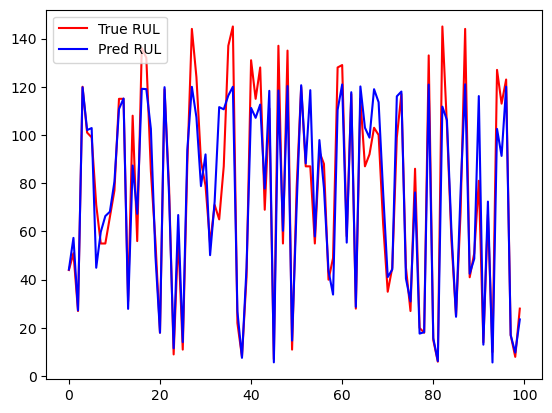

<Figure size 640x480 with 0 Axes>

In [58]:
# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()
#plt.savefig("Actual vs Prediction-last sample for each engine.jpg",dpi=500,bbox_inches="tight")
plt.clf()

In [58]:
indices_of_last_two=np.cumsum(num_test_windows_list)-2
preds_for_last_two= np.concatenate(preds_for_each_engine)[indices_of_last_two]
RMSE_new_two = np.sqrt(mean_squared_error(true_rul, preds_for_last_two))
print("RMSE(Taking only last two samples of each engine) : ",RMSE_new_two)


RMSE(Taking only last two samples of each engine) :  13.92585845322249


In [123]:
import vaex

In [266]:
shap_values[0][11][29]

array([ 0.84727962,  0.0372984 ,  0.03041523, -0.00950982, -4.5715775 ,
       -2.08501973, -1.56521938, -1.05023443, -7.34248144, -0.79981944,
       -0.18607561, -0.35142808, -0.13628239, -0.30061191,  0.08335348])

In [111]:
shap_values[0][10][-1].shape

NameError: name 'shap_values' is not defined

In [156]:
shap_vals[0].shape

(12, 30, 15)

In [157]:
from src import sensor_data

In [158]:
sensor_names_short = [sensor[0] for sensor in sensor_data if sensor[0] in df_explain]

In [235]:
processed_val_data[4000][:].sum(axis=0)

array([-14.25572519,   1.00234192,   5.57565081,   6.79126365,
       -21.68582375,  14.50588235, -18.31362943,   8.21714286,
       -20.98013245,  14.        , -18.4061403 ,  15.93095123,
         4.90909091, -11.96428571, -11.4821412 ])

In [229]:
processed_test_data[0][-1]

array([-0.12977099,  0.00234192, -0.11411235, -0.09297972,  0.0440613 ,
        0.50588235, -0.42570597, -0.09714286, -0.00967906,  0.48809524,
       -0.41604233, -0.25108643, -0.09090909,  0.25      ,  0.06744596])

In [212]:
#one sequence
shap_values[0][11].sum(axis=0)

array([  4.40595789,  -0.79145964,  -2.87516601,  -1.66805141,
       -11.55238823,  -9.84301027,  -7.88357069,  -5.95310038,
       -20.19808954,  -2.16487662,  -2.67519272,  -3.15290779,
        -6.10755873,   5.01307742,   3.23915611])

In [294]:
np.abs(shap_values[0][1]).sum(axis=0)

IndexError: index 12 is out of bounds for axis 0 with size 12

In [286]:
shap_values[0][11]

array([[-2.59245203e+00, -2.03723557e-02,  1.13552937e-01,
         9.04962817e-03,  1.59128760e+00,  1.49696805e+00,
         3.83909631e-01,  7.67219758e-01,  4.17446801e+00,
         8.64914952e-01, -1.19298701e-01,  4.87790948e-01,
        -1.68348935e-02, -4.29222827e-01, -3.65701479e-01],
       [-2.58738636e+00, -2.33263745e-02,  6.71546546e-02,
         9.31156273e-03,  3.87016638e+00,  1.86382865e+00,
         9.69884321e-01,  4.66943006e-01,  6.15217695e+00,
         9.60177363e-01,  6.27718832e-03,  3.64772266e-01,
        -7.63727702e-02,  3.04055467e-02, -1.76515556e-01],
       [-2.82430508e+00, -2.97299154e-02,  4.61636897e-02,
        -1.07490556e-01,  2.99778335e+00,  2.44035427e+00,
         3.83903167e-01,  2.15664169e-01,  5.48214536e+00,
         1.11555869e+00,  1.96394224e-01,  1.66286677e-01,
        -4.87385995e-01, -3.63442452e-01,  3.68886253e-01],
       [-2.43066637e+00,  5.12289428e-02,  1.02643980e-02,
         7.94397363e-02,  4.68283340e+00,  2.36924816

In [67]:
s.values

array([13.17042961, 10.17255527,  7.82424858, 23.04799961, 22.50216321,
       44.88542588, 16.97664629, 42.40739585, 42.62484094, 43.21934515,
        7.18810974,  9.09285388, 15.24076565,  2.66677927, 11.54351325])

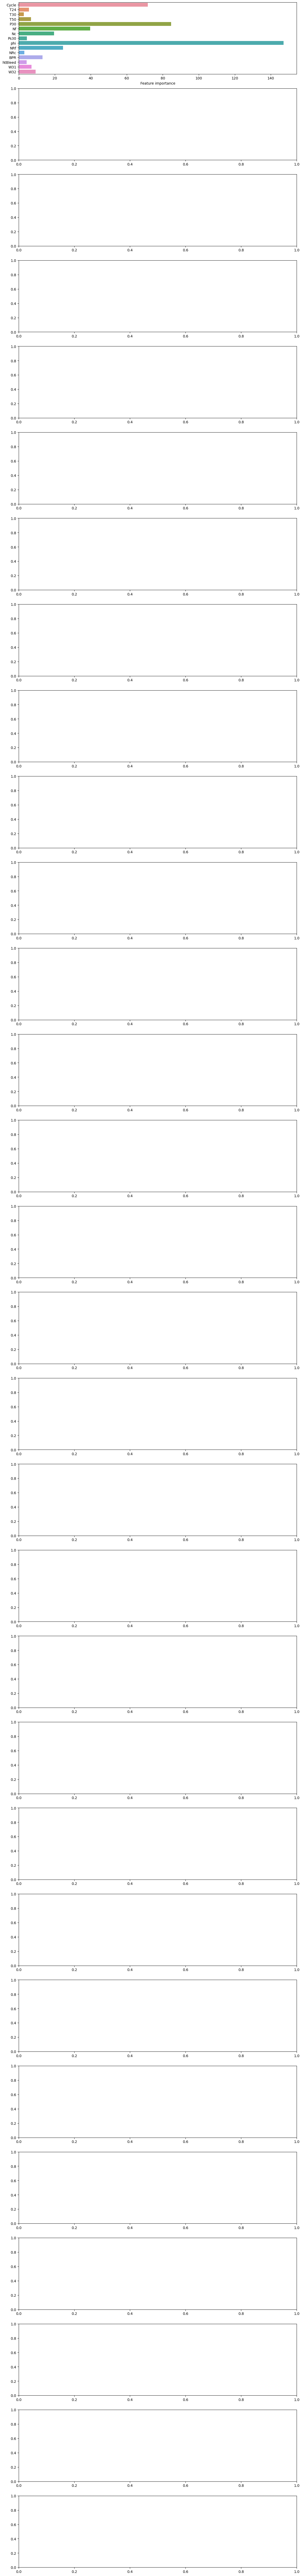

In [215]:
fig, axes = plt.subplots(nrows=30, ncols=1, figsize=(14, 130))
for i in range(30):
    expl = np.abs(shap_values[0][i]).sum(axis=0)
    s = pd.Series(data=expl, index=df_explain.columns)
    s.sort_values()#.plot.barh(figsize=(24, 6))
    sns.barplot(x=s.values,y=s.index ,orient='h',ax=axes[i])
    axes[i].set_xlabel('Feature importance')
    plt.show()
fig.savefig('Feature_importance_30.jpg',dpi=500,bbox_inches='tight')
    

In [70]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]
RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  12.77210056187482


In [325]:
new_pred= reconstructed_model.predict(processed_train_data)
new_pred

array([[ 71.354805],
       [118.481384],
       [119.932686],
       ...,
       [119.35029 ],
       [ 56.62891 ],
       [ 61.598145]], dtype=float32)

In [335]:
true_rul

array([ 44,  51,  27, 120, 101,  99,  71,  55,  55,  66,  77, 115, 115,
        31, 108,  56, 136, 132,  85,  56,  18, 119,  78,   9,  58,  11,
        88, 144, 124,  89,  79,  55,  71,  65,  87, 137, 145,  22,   8,
        41, 131, 115, 128,  69, 111,   7, 137,  55, 135,  11,  78, 120,
        87,  87,  55,  93,  88,  40,  49, 128, 129,  58, 117,  28, 115,
        87,  92, 103, 100,  63,  35,  45,  99, 117,  45,  27,  86,  20,
        18, 133,  15,   6, 145, 104,  56,  25,  68, 144,  41,  51,  81,
        14,  67,  10, 127, 113, 123,  17,   8,  28])

In [ ]:
temp= pd.DataFrame(data=pred)
scaled_temp= test_data[:10].drop(labels=[0],axis=1)
rev_trans = scaler.inverse_transform(scaled_temp)######## Transforming back to original scale-features only
rev_trans =pd.DataFrame(rev_trans)
rev_trans

In [344]:
import_2nd_test=pd.read_csv("test_FD003.txt", sep = "\s+", header = None,names= Names)
import_2nd_test['cycle']

30        31
31        32
32        33
33        34
34        35
        ... 
16591    243
16592    244
16593    245
16594    246
16595    247
Name: cycle, Length: 16566, dtype: int64

In [350]:
rul_pred.shape

(500,)

RMSE(taking only last example for each engine):  12.77210056187482


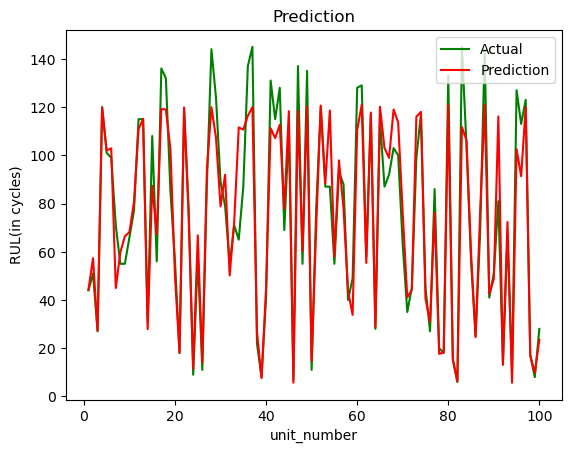

In [389]:
plt.plot(np.arange(1,101,step=1),true_rul,color='g')
plt.plot(np.arange(1,101,step=1),preds_for_last_example,color='r')
plt.xlabel('unit_number')
plt.ylabel('RUL(in cycles)')
plt.legend([ 'Actual','Prediction'], loc='upper right')
plt.title('Prediction')
print("RMSE(taking only last example for each engine): ",RMSE_new)
plt.show()


In [69]:
shap_values.shape

NameError: name 'shap_values' is not defined

In [68]:
preds_for_last_example

array([ 44.210373 ,  57.330532 ,  27.281216 , 119.77777  , 102.05449  ,
       102.87095  ,  44.944523 ,  59.80096  ,  66.38344  ,  68.17321  ,
        80.66406  , 110.78511  , 115.13094  ,  27.889652 ,  87.34411  ,
        67.30999  , 119.15992  , 119.01503  , 102.55835  ,  49.88115  ,
        18.015427 , 119.83462  ,  74.652405 ,  11.573588 ,  66.81504  ,
        14.115281 ,  93.7801   , 119.973404 , 107.3266   ,  78.810135 ,
        91.94892  ,  50.162876 ,  72.340515 , 111.558495 , 110.64924  ,
       116.36783  , 119.99198  ,  26.833527 ,   7.5852747,  44.945168 ,
       111.23241  , 107.12028  , 112.629875 ,  77.779785 , 118.31468  ,
         5.7108154, 118.45281  ,  60.27766  , 120.284096 ,  14.752244 ,
        70.10151  , 120.63325  ,  88.236885 , 118.591225 ,  57.933792 ,
        97.89764  ,  77.99295  ,  43.634174 ,  33.82982  , 110.45555  ,
       120.957664 ,  55.36813  , 117.738815 ,  28.716135 , 120.13359  ,
       103.02276  ,  98.908005 , 118.99429  , 113.596924 ,  76.0

In [376]:
indices_of_last_two=np.cumsum(num_test_windows_list)-2

In [ ]:

import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import shap
shap.initjs()

In [378]:
np.concatenate(preds_for_each_engine)[indices_of_last_examples]

array([ 44.210373 ,  57.330532 ,  27.28122  , 119.77778  , 102.05449  ,
       102.87095  ,  44.94452  ,  59.80096  ,  66.38344  ,  68.17321  ,
        80.66406  , 110.78511  , 115.13094  ,  27.889652 ,  87.34411  ,
        67.30999  , 119.15992  , 119.01503  , 102.55835  ,  49.88115  ,
        18.015429 , 119.83463  ,  74.652405 ,  11.573588 ,  66.81504  ,
        14.115281 ,  93.7801   , 119.973404 , 107.3266   ,  78.810135 ,
        91.94892  ,  50.162876 ,  72.340515 , 111.558495 , 110.64924  ,
       116.36783  , 119.99198  ,  26.833527 ,   7.5852747,  44.945175 ,
       111.23241  , 107.12028  , 112.629875 ,  77.77978  , 118.31468  ,
         5.7108154, 118.45281  ,  60.27766  , 120.284096 ,  14.752246 ,
        70.10151  , 120.63325  ,  88.236885 , 118.591225 ,  57.933792 ,
        97.89764  ,  77.99295  ,  43.634174 ,  33.82982  , 110.45555  ,
       120.957664 ,  55.368122 , 117.738815 ,  28.716135 , 120.13359  ,
       103.02276  ,  98.908005 , 118.99429  , 113.596924 ,  76.0

In [380]:
np.concatenate(preds_for_each_engine)[indices_of_last_two]

array([ 46.250816 ,  54.360115 ,  28.862564 , 118.60376  , 115.77699  ,
       110.45373  ,  50.44687  ,  65.700584 ,  71.29584  ,  68.99366  ,
        76.57268  , 111.53904  , 113.938965 ,  28.085556 ,  91.32695  ,
        69.86387  , 119.64306  , 117.98507  , 103.32587  ,  49.132042 ,
        18.719776 , 119.998604 ,  76.01241  ,   9.142017 ,  69.02354  ,
        15.8257885,  96.13999  , 120.17034  , 108.45244  ,  81.36517  ,
       102.00806  ,  56.80973  ,  80.673485 , 109.24157  , 112.56781  ,
       117.89758  , 119.863815 ,  30.853418 ,   8.604802 ,  43.65756  ,
       109.75198  , 106.60507  , 106.81598  ,  74.02608  , 118.67783  ,
         7.649496 , 118.776596 ,  52.05445  , 118.828094 ,  14.991851 ,
        72.93191  , 120.60983  ,  82.75277  , 118.460625 ,  64.943855 ,
        97.916245 ,  75.54115  ,  43.134758 ,  34.69744  , 105.19263  ,
       120.65005  ,  55.066116 , 116.88374  ,  28.992247 , 119.65398  ,
       102.04344  ,  94.919556 , 119.43787  , 115.45866  ,  72.6

In [383]:
np.mean([np.concatenate(preds_for_each_engine)[indices_of_last_examples],np.concatenate(preds_for_each_engine)[indices_of_last_two]],axis=0)

array([ 45.230595 ,  55.84532  ,  28.071892 , 119.190765 , 108.91574  ,
       106.66234  ,  47.695694 ,  62.75077  ,  68.83964  ,  68.583435 ,
        78.61837  , 111.16208  , 114.53496  ,  27.987604 ,  89.335526 ,
        68.58693  , 119.40149  , 118.500046 , 102.94211  ,  49.506596 ,
        18.367603 , 119.91662  ,  75.33241  ,  10.357803 ,  67.91929  ,
        14.970535 ,  94.960045 , 120.07187  , 107.88952  ,  80.087654 ,
        96.978485 ,  53.486305 ,  76.507    , 110.40003  , 111.60852  ,
       117.132706 , 119.9279   ,  28.843472 ,   8.095038 ,  44.30137  ,
       110.492195 , 106.86267  , 109.72293  ,  75.90292  , 118.49626  ,
         6.6801558, 118.6147   ,  56.166054 , 119.55609  ,  14.872048 ,
        71.51671  , 120.62154  ,  85.49483  , 118.525925 ,  61.438824 ,
        97.90694  ,  76.76705  ,  43.384468 ,  34.26363  , 107.82409  ,
       120.803856 ,  55.217117 , 117.31128  ,  28.85419  , 119.89378  ,
       102.5331   ,  96.91378  , 119.21608  , 114.52779  ,  74.3

Calculating RMSE by taking the average of last two examples(test windows) for each engine.

In [385]:
preds_for_last_two

NameError: name 'preds_for_last_two' is not defined

In [388]:
indices_of_last_two=np.cumsum(num_test_windows_list)-2
preds_for_last_two=np.concatenate(preds_for_each_engine)[indices_of_last_two]
preds_avg_last_two= np.mean([preds_for_last_example,preds_for_last_two],axis=0)
RMSE_try= np.sqrt(mean_squared_error(true_rul,preds_avg_last_two))
print("RMSE (Taking only last two examples): ", RMSE_try)

RMSE (Taking only last two examples):  13.042272490320926


In [76]:
tcn_lstm_metrics= get_regression_metrics('TCN-LSTM-last-example for each engine',true_rul,preds_for_last_example)
tcn_lstm_metrics

,TCN-LSTM-last-example for each engine
Root Mean Squared Error,12.772101
Mean Absolute Error,8.888184
R^2,0.904805
Explained Variance,0.905128
MAPE,0.123437


In [104]:
processed_train_data[2].shape

(30, 15)

In [103]:
processed_train_targets.shape

(17456,)

In [110]:
pip install keras-flops==0.1.1

  Using cached keras_flops-0.1.1-py3-none-any.whl (5.2 kB)
INFO: pip is looking at multiple versions of keras-flops to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement tensorflow<3.0,>=2.2 (from keras-flops) (from versions: 2.13.0rc0)
ERROR: No matching distribution found for tensorflow<3.0,>=2.2
Note: you may need to restart the kernel to use updated packages.


In [107]:
tensorflow.__version__

'2.9.0'